# Notebook to explore files and test ML stuff on intrinsic data set 

The idea is to compare this to Rikhav's cut based analysis. 

In [1]:
import numpy as np
import glob
import os
import tqdm
import itertools
import matplotlib.pyplot as plt
import time
import copy
from fastespy.readpydata import convert_data_to_ML_format
from fastespy.plotting import plot_2d_hist, plot_scatter_w_hist

In [2]:
%matplotlib inline

### Explore the data

Let's take a look at the data from Rikhav's intrinsic runs, done at $R_N = 0.3$ and a gain width product of 1.5 GHz. The trigger threshold was set to 20mV.

In [3]:
path = "../../../data-01152021/"
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
print(files[0])

17
../../../data-01152021/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy


Load one file and inspect it's contents:

In [4]:
x = np.load(files[0], allow_pickle=True).tolist()
print(len(x.keys()))  # number of recorded triggers
#print(x.keys())  # in Rikhav's files, the keys are integers from 1,..., N_trigger 
x[1]

1709


{'start time in hrs': 0.01628305595,
 'end time in hrs': 0.0162831115,
 'data': array([-0.0012398 , -0.00112535, -0.00089647, ...,  0.00028611,
        -0.00024796,  0.00020981]),
 'time': array([58.61900142, 58.61900144, 58.61900146, ..., 58.61920136,
        58.61920138, 58.6192014 ]),
 'rise time': 1.7650903275199694e-06,
 'rise time error': 1.5309936511128432e-08,
 'decay time': 2.287605898160283e-05,
 'decay time error': 2.5212876321734424e-07,
 'constant': 0.0004085272957005441,
 'constant error': 3.960175446925966e-05,
 'amplitude': 0.01804428397975213,
 'amplitude error': 7.416273727863304e-05,
 'pulse integral raw': -7.72645215374739e-07,
 'pulse integral raw error': 3.000000248221113e-07,
 'pulse height': -0.031212677749656446,
 'pulse height error': 0.0014603982455307404,
 'trigger time': 2.966826527028843e-05,
 'chi2 reduced': 1.7620628040853559,
 'voltage error': 0.0015,
 'pulse integral fit': -8.3209149181234e-07}

From this first look, define the key words that you would like to save

In [18]:
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
         ]

for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

print(feature_names)

['rise time', 'decay time', 'constant', 'amplitude', 'pulse height', 'chi2 reduced', 'pulse integral fit']


In [19]:
result = {'type': []}
t_tot_hrs = 0.

# loop through files
for f in tqdm.tqdm(files): 
    x = np.load(f, allow_pickle=True).tolist()

    # for each file: calculate observation time
    t_start = 1e10
    t_stop = 0.
    # loop through triggers
    for i in range(1,len(x.keys())+1):
        for name in feature_names:
            if not name in result.keys():
                result[name] = []
                
            result[name].append(x[i][name])
        
        if 'intrinsic' in f:
            if x[i]['end time in hrs'] > t_stop:
                t_stop = x[i]['end time in hrs']
            if x[i]['start time in hrs'] < t_start:
                t_start = x[i]['start time in hrs']
            result['type'].append(0)
        
        if 'light' in f:
            result['type'].append(1)

    if 'intrinsic' in f:
        t_tot_hrs += t_stop - t_start  # only add for dark count rate

# convert into into numpy arrays
for k, v in result.items():
    if k == 'type':
        dtype = np.bool
    else:
        dtype = np.float32
    result[k] = np.array(v, dtype=dtype)

100%|██████████| 17/17 [00:07<00:00,  2.21it/s]


In [20]:
len(result['rise time'])

42207

### Plot some histograms

Rikhav said the following: "The fit parameters I use for then selecting data are pulse height, amplitude, pulse integral, the exponential rise and decay times, and the chi2"

In [28]:
# define labels
label = {
    'rise time': r'Rise time $(\mu\mathrm{s})$',
    'decay time': r'Decay time $(\mu\mathrm{s})$',
    'pulse height': r'Pulse height (mV)',
    'amplitude': r'Amplitude (mV)',
    'pulse integral fit': r'Pulse Integral (mV $\mu$s)',
    'chi2 reduced': r'$\chi^2/$d.o.f.',
    'constant': 'Constant offset (mV)'
}

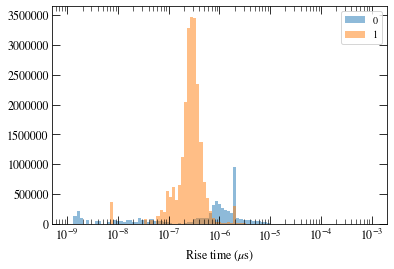

In [29]:
k = 'rise time'
bins = np.logspace(-9., -3., 100)

for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, density=True, alpha=0.5)

plt.legend()
plt.xlabel(label[k])
plt.gca().set_xscale('log')

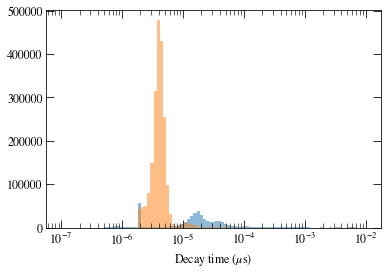

In [30]:
k = 'decay time'
bins = np.logspace(-7., -2., 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')

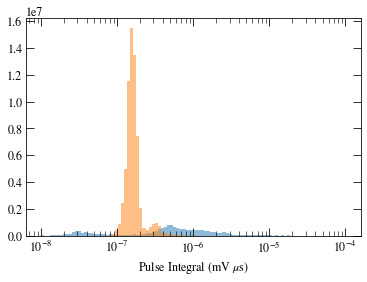

In [31]:
k = 'pulse integral fit'
bins = np.logspace(-8., -4., 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(-result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')

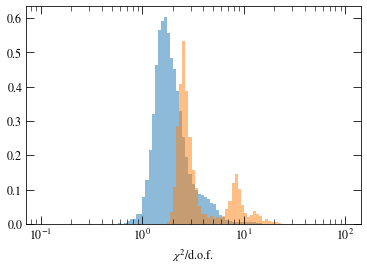

In [32]:
k = 'chi2 reduced'
bins = np.logspace(-1, 2, 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')

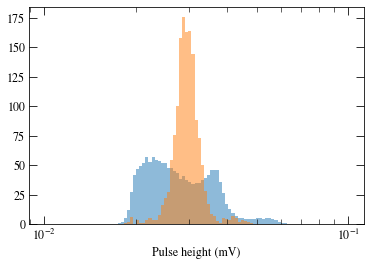

In [33]:
k = 'pulse height'
bins = np.logspace(-2, -1, 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(-result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')

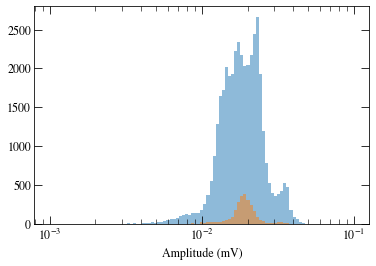

In [43]:
k = 'amplitude'
bins = np.logspace(-3, -1, 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')

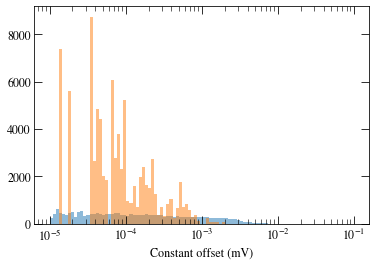

In [35]:
k = 'constant'
bins = np.logspace(-5, -1, 100)
for i in range(2):
    m = result['type'] == i
    plt.hist(result[k][m], bins=bins, label=i, density=True, alpha=0.5)
plt.xlabel(label[k])
plt.gca().set_xscale('log')

# Apply machine learning

Test machine learning algorithms to separate light from background.

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import get_scorer, make_scorer, fbeta_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [45]:
X, y = convert_data_to_ML_format(result, feature_names, bkg_type=0, signal_type=1)

In [46]:
print(np.sum(y == 1), np.sum(y == 0))

2627 39580


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y, # use class labels, since large imbalance between light and bkg
                                                    test_size=0.2
                                                    )

In [137]:
# preprocess data: zero mean, standard deviation of 1
scaler = StandardScaler().fit(X_train)
print(scaler.mean_)
print(scaler.scale_)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.mean(axis=0))
print(X_train_scaled.std(axis=0))

print(X_test_scaled.mean(axis=0))
print(X_test_scaled.std(axis=0))

[ 2.83844064e-06  4.07742613e-05  8.09105469e-04  1.91716572e-02
 -3.09358507e-02  3.12724394e+00 -1.37544670e-06]
[1.16744351e-05 5.24398759e-05 3.80342121e-03 6.80674070e-03
 9.02881672e-03 2.83112367e+00 1.16073526e-06]
[-2.41789986e-16  6.06323488e-18  2.12917077e-17  2.13262121e-16
 -3.61903442e-17  1.84198708e-17  9.67791258e-17]
[1. 1. 1. 1. 1. 1. 1.]
[-0.00058068  0.04254445  0.00350468  0.01225276 -0.01970591  0.02025896
 -0.01458494]
[0.54453729 2.17277558 0.64801249 0.92800992 0.98227279 1.07192081
 0.87812632]


In [48]:
print(np.sum(y_train == 1), np.sum(y_train == 0))
print(np.sum(y_test == 1), np.sum(y_test == 0))

2102 31663
525 7917


In [49]:
# With the test data, perform a K-fold cross validation to
# find the best hyper parameters.
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # retain same percentage of bkg/light samples in each fold

Classifiers and parameter grids for hyper parameter optimization:

In [159]:
clf = dict(
    dt=DecisionTreeClassifier,
    bdt=GradientBoostingClassifier,
    rf=RandomForestClassifier,
    mlp=MLPClassifier
)

In [169]:
param_grid = dict(
    dt={'ccp_alpha': np.linspace(0., 0.001, 5),
        'min_samples_split': np.arange(2, 53, 10),
        'max_depth': np.arange(2, 21, 1)
        },
#    bdt={'n_estimators': np.arange(100, 1100, 200),
#         'learning_rate': np.arange(0.1, 1.1, 0.2),
#         'max_depth': np.arange(2, 6, 2)
#         },
# smaller grid
    bdt={'n_estimators': np.arange(100, 1100, 400),
         'learning_rate': np.arange(0.1, 1.1, 0.4),
         'max_depth': np.arange(2, 10, 3)
         },

    rf={'n_estimators': np.arange(100, 600, 200),
        'max_features': np.arange(1, 6, 2),
        'min_samples_split': np.arange(2, 82, 20),
        },
    mlp={
        'hidden_layer_sizes': ((10,), (50,), (10, 10), (50, 50), (10, 10, 10), (50, 50, 50)),
        'alpha': 10.**np.arange(-4, 0.5, 0.5)
        }
)

In [161]:
default_pars = dict(
    dt={'criterion': 'gini',
        'min_samples_leaf': 1,
        },
    bdt={'loss': 'deviance',
         'min_samples_split': 2
         },
    rf={'criterion': 'gini',
        'max_depth': None,  # fully grown trees
        },
    mlp={'learning_rate' : 'constant',
         'activation': 'relu',
         'max_iter': 1000,
         'solver': 'adam',
         'shuffle': True,
         'tol': 1e-4
         }
)

Generate my own scorer the optimizes the detection significance. 
Numbers taken from ALPS design requirement document.

In [162]:
def significance_scorer(y, y_pred, 
                        n_s=2.8e-5,  # assumed signal rate in Hz
                        e_d=0.5,  # detector efficiency
                        t_obs=20. * 24. * 3600., # observation time in seconds
                        N_tot=1000  # total number of triggers for t_obs
                       ):
    """
    Scorer that scales upwards for better detection significance, 
    see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
    
    Parameters
    ----------
    y: array-like
        true labels
    
    y_pred: array-like
        predicted labels
    
    t_obs: float
        observation time in seconds
    
    n_s: float
        signal rate from regenerated photons
        
    e_d: fload
        Detector efficiency
        
    N_tot: int
        Total number of triggers recorded in t_obs
        
    Returns
    -------
    Detection significance
    """
    
    # true positive rate
    # this is also the analysis efficiency
    tp_rate = np.sum(y * y_pred) / float(np.sum(y))
    
    # misidentified background events
    # false positive rate
    fp_rate = np.sum((y_pred == 1) & (y == 0)) / float(len(y)) 
    # from this, you get the dark current
    n_b = fp_rate * N_tot / t_obs
    
    S = 2. * (np.sqrt(e_d * tp_rate * n_s + n_b) - np.sqrt(n_b)) * np.sqrt(t_obs)
    return S
        

Create a scorer

In [163]:
sig_score = make_scorer(significance_scorer,
                        greater_is_better=True,
                        t_obs=t_tot_hrs * 3600.,
                        N_tot=y.size)

The scoring options:

In [164]:
scoring = {'AUC': 'roc_auc',
           'Accuracy': 'accuracy',
           #'Precision': 'precision',
           'Significance': sig_score
#           'Recall': 'recall',
#           'F_1': 'f1',
#           'F_2': make_scorer(fbeta_score, beta=2),
#           'F_{1/2}': make_scorer(fbeta_score, beta=0.5),
           }

In [165]:
refit = 'Significance'

Which classifier to test:

In [170]:
classifier = 'dt'
classifier = 'bdt'
print(param_grid[classifier])

{'n_estimators': array([100, 500, 900]), 'learning_rate': array([0.1, 0.5, 0.9]), 'max_depth': array([2, 5, 8])}


In [171]:
gs = GridSearchCV(clf[classifier](random_state=42, **default_pars[classifier]),
                  param_grid=param_grid[classifier],
                  scoring=scoring,
                  refit=refit,
                  #scoring=sig_score,  #only use significance
                  #refit=True,
                  return_train_score=True,
                  cv=kf,
                  verbose=1,
                  n_jobs=8
                  )

In [172]:
t0 = time.time()
#gs.fit(X_train, y_train)
gs.fit(X_train_scaled, y_train)

t1 = time.time()
print("The parameter search took {0:.2f} s".format(t1-t0))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 135 out of 135 | elapsed:  8.4min finished


The parameter search took 542.26 s


In [173]:
results = dict(gs_cv=gs.cv_results_)

### Post processing

In [174]:
def profile_params(results, scoring, clfid):
    """
    Profile the parameters.
    For each value of a parameter, compute
    the best mean test and train scores and standard deviations
    from profiling, i.e., for each value of a parameter
    set the other grid parameters to the values that maximize the score.
    """
    mean_best_test = {}
    mean_best_train = {}
    std_best_test = {}
    std_best_train = {}

    for score in scoring.keys():

        mean_best_test[score] = {}
        mean_best_train[score] = {}
        std_best_test[score] = {}
        std_best_train[score] = {}

        for param, v in param_grid[clfid].items():

            mean_best_test[score][param] = np.zeros_like(v).astype(np.float)
            mean_best_train[score][param] = np.zeros_like(v).astype(np.float)
            std_best_test[score][param] = np.zeros_like(v).astype(np.float)
            std_best_train[score][param] = np.zeros_like(v).astype(np.float)

            for i, vi in enumerate(v):
                # create a mask where flattened param array corresponds to k = vi
                if param == 'hidden_layer_sizes':
                    m = []
                    for x in results['param_hidden_layer_sizes'].data:
                        m.append(x == vi)
                    m = np.array(m)
                else:
                    m = results[f'param_{param}'] == vi
                # get the best value for this vi
                idmax_test = np.argmax(results[f'mean_test_{score}'][m])
                idmax_train = np.argmax(results[f'mean_train_{score}'][m])

                mean_best_test[score][param][i] = results[f'mean_test_{score}'][m][idmax_test]
                std_best_test[score][param][i] = results[f'std_test_{score}'][m][idmax_test]

                mean_best_train[score][param][i] = results[f'mean_train_{score}'][m][idmax_train]
                std_best_train[score][param][i] = results[f'std_train_{score}'][m][idmax_train]

    return mean_best_test, std_best_test, mean_best_train, std_best_train

In [175]:
mt, st, mtr, sstr = profile_params(gs.cv_results_, scoring, classifier)

In [177]:
results['profile'] = dict(mean_test=mt, std_test=st, mean_train=mtr, std_train=sstr)

# loop over scoring:
# get the best param index
# and for the estimator with these params,
# calcuate the score.
results['best_params'] = dict()
results['score_validation'] = dict()
results['learning_curve'] = dict()
results['confusion_matrix_test'] = dict()
results['confusion_matrix_train'] = dict()
results['classification_report'] = dict()
results['bkg_pred_test'] = dict()
results['tp_efficiency_test'] = dict()
results['bkg_pred_train'] = dict()
results['tp_efficiency_train'] = dict()
results['score_train'] = dict()

# for learning curve
train_sizes = (np.arange(0.1, 0.9, 0.1) * y_train.shape).astype(np.int)

#X_use_test = X_test
#X_use_train = X_train

X_use_test = X_test_scaled
X_use_train = X_train_scaled

for k, v in scoring.items():

    scorer = get_scorer(v)
    # get the best index for parameters
    best_index = np.nonzero(gs.cv_results_[f'rank_test_{k:s}'] == 1)[0][0]
    results['best_params'][k] = copy.deepcopy(default_pars[classifier])
    results['best_params'][k].update(gs.cv_results_['params'][best_index])

    # init an estimator with the best parameters
    #if k == 'Significance':
    #    results['best_params'][k]['max_depth'] = 19
    #    results['best_params'][k]['min_samples_split'] = 2
    best_clf = clf[classifier](random_state=42, **results['best_params'][k])
    best_clf.fit(X_use_train, y_train)

    y_pred_test = best_clf.predict(X_use_test)
    y_pred_train = best_clf.predict(X_use_train)

    results['score_validation'][k] = scorer(best_clf, X_use_test, y_test)
    results['score_train'][k] = scorer(best_clf, X_use_train, y_train)

    # create a learning curve for the best classifier
    train_sizes, train_scores, valid_scores = learning_curve(best_clf, X_use_train, y_train,
                                                             train_sizes=train_sizes,
                                                             cv=kf,
                                                             verbose=1,
                                                             n_jobs=8)

    results['learning_curve'][k] = (train_sizes, train_scores, valid_scores)

    # get the confusion matrix for the best classifier
    results['confusion_matrix_test'][k] = confusion_matrix(y_test, y_pred_test)
    results['confusion_matrix_train'][k] = confusion_matrix(y_train, y_pred_train)

    # get the classification report for the best classifier
    results['classification_report'][k] = classification_report(y_test, y_pred_test,
                                                                output_dict=True,
                                                                labels=[0, 1],
                                                                target_names=['bkg', 'light']
                                                                )

    fp_test = results['confusion_matrix_test'][k][0,1]  # false positive
    fp_test_rate = fp_test / y_pred_test.size  # false positive rate
    results['bkg_pred_test'][k] = fp_test_rate * y.size
    
    fp_train = results['confusion_matrix_train'][k][0,1]  # false positive
    fp_train_rate = fp_test / y_pred_train.size  # false positive rate
    results['bkg_pred_train'][k] = fp_train_rate * y.size
    
    # efficiency of identifying light
    tp_test = results['confusion_matrix_test'][k][1,1]  # true positive
    tp_train = results['confusion_matrix_train'][k][1,1]  # true positive
    results['tp_efficiency_test'][k] = tp_test / (y_test == 1).sum()
    results['tp_efficiency_train'][k] = tp_train / (y_train == 1).sum()

[learning_curve] Training set sizes: [ 3376  6753 10129 13506 16882 20259 23635 27012]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  3.0min finished


[learning_curve] Training set sizes: [ 3376  6753 10129 13506 16882 20259 23635 27012]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  2.4min finished


[learning_curve] Training set sizes: [ 3376  6753 10129 13506 16882 20259 23635 27012]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  2.5min finished


In [180]:
for k, v in scoring.items():
    print(k, results['best_params'][k])

AUC {'loss': 'deviance', 'min_samples_split': 2, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 900}
Accuracy {'loss': 'deviance', 'min_samples_split': 2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Significance {'loss': 'deviance', 'min_samples_split': 2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


In [181]:
for k, v in scoring.items():
    print(k, results['score_validation'][k], results['score_train'][k])

AUC 0.9998407285106792 1.0
Accuracy 0.9973939824686093 1.0
Significance 2.9181554313336378 10.218114061346759


## Plot the results

First plot the **parameter profiles**

n_estimators
learning_rate
max_depth


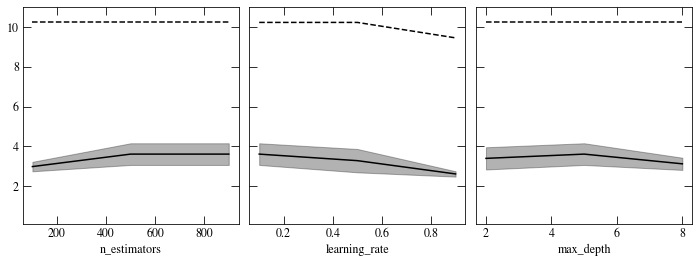

In [182]:
plt.figure(figsize=(4*3, 4))
ax = []
for i, score in enumerate(['Significance']):
    color = 'g' if score == 'AUC' else 'k'
    color = 'r' if score == 'Accuracy' else color
    for j, par in enumerate(results['profile']['mean_test'][score].keys()):
        
        if not i:
            ax.append(plt.subplot(1,len(results['profile']['mean_test'][score].keys()), j+1))
        
        print (par)
        if par == 'hidden_layer_sizes':
            
            x = np.unique([np.sum(results['gs_cv'][f'param_{par}'].data[i]) for i in \
                           range(results['gs_cv'][f'param_{par}'].data.size)])
        
        else:
            x = np.unique(results['gs_cv'][f'param_{par}'].data).astype(np.float)
        
        for t in ['test', 'train']:
            ax[j].plot(x, results['profile'][f'mean_{t:s}'][score][par],
                       color=color, 
                       ls='-' if t == 'test' else '--',
                       label=score + " " + t
                      )
        
            if t == 'test':
                ax[j].fill_between(x, results['profile'][f'mean_{t:s}'][score][par] - \
                                       0.5 * results['profile'][f'std_{t:s}'][score][par],
                                   y2=results['profile'][f'mean_{t:s}'][score][par] + \
                                       0.5 * results['profile'][f'std_{t:s}'][score][par],
                                   color=color,
                                   alpha=0.3)
        
        if not i:
            ax[j].set_xlabel(par)
        else:
            ax[j].legend()
            #ax[j].set_ylim(0.92,1.001)
            #ax[j].grid()
        if j:
            ax[j].tick_params(labelleft=False)
        ax[j].set_ylim(0.1,11.)  
plt.subplots_adjust(wspace = 0.05)

n_estimators
learning_rate
max_depth
n_estimators
learning_rate
max_depth


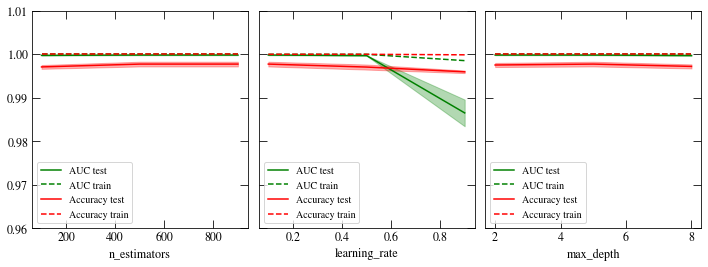

In [183]:
plt.figure(figsize=(4*3, 4))
ax = []
#for i, score in enumerate(['AUC', 'Accuracy', 'Precision']):
for i, score in enumerate(['AUC', 'Accuracy']):
    color = 'g' if score == 'AUC' else 'k'
    color = 'r' if score == 'Accuracy' else color
    for j, par in enumerate(results['profile']['mean_test'][score].keys()):
        
        if not i:
            ax.append(plt.subplot(1,len(results['profile']['mean_test'][score].keys()), j+1))
        
        print (par)
        if par == 'hidden_layer_sizes':
            
            x = np.unique([np.sum(results['gs_cv'][f'param_{par}'].data[i]) for i in \
                           range(results['gs_cv'][f'param_{par}'].data.size)])
        
        else:
            x = np.unique(results['gs_cv'][f'param_{par}'].data).astype(np.float)
        
        for t in ['test', 'train']:
            ax[j].plot(x, results['profile'][f'mean_{t:s}'][score][par],
                       color=color, 
                       ls='-' if t == 'test' else '--',
                       label=score + " " + t
                      )
        
            if t == 'test':
                ax[j].fill_between(x, results['profile'][f'mean_{t:s}'][score][par] - \
                                       0.5 * results['profile'][f'std_{t:s}'][score][par],
                                   y2=results['profile'][f'mean_{t:s}'][score][par] + \
                                       0.5 * results['profile'][f'std_{t:s}'][score][par],
                                   color=color,
                                   alpha=0.3)
        
        if not i:
            ax[j].set_xlabel(par)
        else:
            ax[j].legend()
            #ax[j].set_ylim(0.92,1.001)
            ax[j].set_ylim(1.,10.)
            #ax[j].grid()
        if j:
            ax[j].tick_params(labelleft=False)
        ax[j].set_ylim(0.96,1.01)  
plt.subplots_adjust(wspace = 0.05)

Plot the **learning curve**

Text(0, 0.5, 'Score')

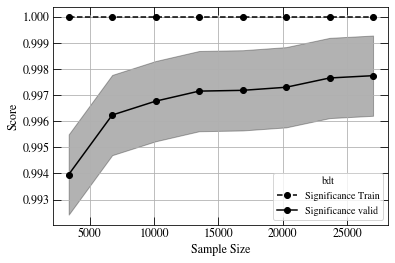

In [184]:
for score, val in results['learning_curve'].items():
    
    if not score == 'Significance':
        continue
    
    train_sizes, train_scores, valid_scores = val
    
    plt.plot(train_sizes, train_scores.mean(axis=1),
             marker='o',
             label=score + " Train",
             ls='--',
             color='g' if score == 'AUC' else 'k'
            )
    plt.fill_between(train_sizes,
                     train_scores.mean(axis=1) - np.sqrt(train_scores.var()),
                     y2=train_scores.mean(axis=1) + np.sqrt(train_scores.var()),
                     alpha=0.3,
                     color='g' if score == 'AUC' else 'k',
                     zorder=-1
                    )
    
    plt.plot(train_sizes, valid_scores.mean(axis=1),
             marker='o',
             label=score + " valid", ls='-',
             color= 'g' if score == 'AUC' else 'k',
            )
    plt.fill_between(train_sizes,
                     valid_scores.mean(axis=1) - np.sqrt(valid_scores.var()),
                     y2=valid_scores.mean(axis=1) + np.sqrt(valid_scores.var()),
                     alpha=0.3,
                     color='g' if score == 'AUC' else 'k',
                     zorder=-1
                    )

plt.legend(title=classifier)
plt.grid()
plt.xlabel("Sample Size")
plt.ylabel("Score")


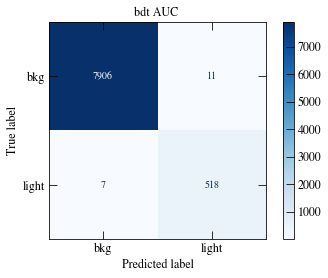

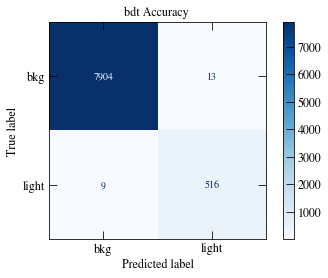

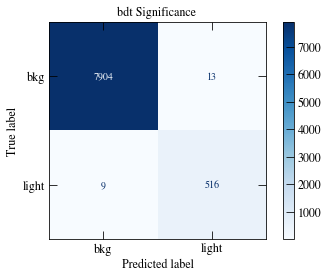

In [185]:
for score in scoring.keys():
    disp = ConfusionMatrixDisplay(np.array(results['confusion_matrix_test'][score]),
                                  display_labels=['bkg', 'light'])
    disp.plot(cmap=plt.cm.Blues,
              #ax=ax,
              values_format="d")
    plt.title(f"{classifier}" + f" {score} ")

In [193]:
keys = ['bkg_pred', 'tp_efficiency', 'score']

for k in scoring.keys():
    for ki in keys:
        print("==== {0:s} : {1:s} ====".format(k, ki))
        if not ki == 'score':
            for t in ['test', 'train']:
                if ki == 'bkg_pred':
                    c = t_tot_hrs * 3600.
                else:
                    c = 1.
                print("{0:s}: {1:.3e}".format(t,
                                              results['{0:s}_{1:s}'.format(ki, t)][k] 
                                              / c))
        else:
            for t in ['train', 'validation']:
                print("{0:s}: {1:.3e}".format(t,
                                              results['{0:s}_{1:s}'.format(ki, t)][k]))

==== AUC : bkg_pred ====
test: 2.950e-05
train: 7.375e-06
==== AUC : tp_efficiency ====
test: 9.867e-01
train: 1.000e+00
==== AUC : score ====
train: 1.000e+00
validation: 9.998e-01
==== Accuracy : bkg_pred ====
test: 3.486e-05
train: 8.716e-06
==== Accuracy : tp_efficiency ====
test: 9.829e-01
train: 1.000e+00
==== Accuracy : score ====
train: 1.000e+00
validation: 9.974e-01
==== Significance : bkg_pred ====
test: 3.486e-05
train: 8.716e-06
==== Significance : tp_efficiency ====
test: 9.829e-01
train: 1.000e+00
==== Significance : score ====
train: 1.022e+01
validation: 2.918e+00


In [194]:
print(results['tp_efficiency_test']['Significance'])
print(results['tp_efficiency_train']['Significance'])

0.9828571428571429
1.0


In [195]:
print(results['score_validation']['Significance'])
print(results['score_train']['Significance'])

2.9181554313336378
10.218114061346759


### Plot the sensitivity

In [196]:
def significance(n_b, obs_time, n_s = 2.8e-5, e_d=0.5, e_a=1.):
    """Signficance of a signal given some background rate and obs time"""
    N_b = obs_time * n_b
    N_s = obs_time * n_s
    eps = e_d * e_a
    S = 2. * (np.sqrt(eps * N_s + N_b) - np.sqrt(N_b))
    return S

In [197]:
# sensitivity from Rikhav's result
print(significance(7.52e-6, obs_time=t_tot_hrs * 3600., n_s = 2.8e-5, e_d=0.5, e_a=0.82))

4.414883729476727


Text(0, 0.5, 'Signficance $S$')

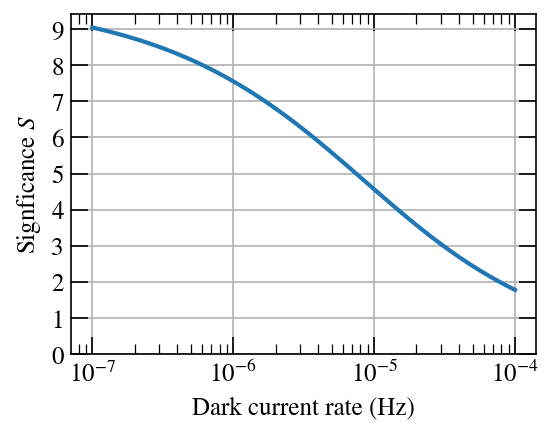

In [285]:
plt.figure(figsize=(4,3), dpi=150)
n_b = np.logspace(-7., -4., 100)
obs_time = 20. * 24. * 3600.
plt.semilogx(n_b, significance(n_b, obs_time=obs_time), lw=2)
plt.grid()
plt.yticks(np.arange(10))
plt.xlabel("Dark current rate (Hz)")
plt.ylabel("Signficance $S$")